In [1]:
from github import Github
from IPython.display import display, HTML

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import os

ROLLING_WINDOW = 5

In [2]:
import logging
logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger('urllib3').setLevel(logging.INFO)
logging.getLogger('github').setLevel(logging.INFO)
log = logging.getLogger(__name__)

In [3]:
GITHUB_TOKEN = os.getenv('GITHUB_PUBLIC_READ_TOKEN')
assert GITHUB_TOKEN is not None

In [4]:
CSV_PATH = 'CSV'
GITHUB_REPO = 'CSSEGISandData/COVID-19'

def get_csvs():
    g = Github(login_or_token=GITHUB_TOKEN)
    repo = g.get_repo(GITHUB_REPO)
    c = repo.get_contents('csse_covid_19_data/csse_covid_19_daily_reports')

    local_csvs = glob.glob(os.path.join(CSV_PATH, '*.csv'))
    local_csvs = list(map(os.path.basename, local_csvs))
    need_dowload = [f for f in c if f.path.endswith('.csv') and os.path.basename(f.path) not in local_csvs]
    for cf in need_dowload:
        fn = os.path.basename(cf.path)
        log.info(f'writing {fn}')
        with open(os.path.join(CSV_PATH, fn), 'wb') as f:
            f.write(cf.decoded_content)

In [5]:
get_csvs()

In [6]:
def path_to_date(path):
    path = os.path.basename(path)
    path = os.path.splitext(path)[0]
    date = pd.Timestamp(f'{path[-4:]}-{path[:2]}-{path[3:5]}')
    return date

def df_from_csv(path):
    column_info = {
        'FIPS': '',
        'Admin2': '',
        'Province_State': 'Province/State',
        'Country_Region': 'Country/Region',
        'Last_Update': 'Last Update',
        'Lat': 'Latitude',
        'Long_': 'Longitude',
        'Confirmed': 'Confirmed',
        'Deaths': 'Deaths',
        'Recovered': 'Recovered',
        'Active': '',
        'Combined_Key': '',
    }

    def combined_key(row):
        keys = ['Admin2', 'Province_State', 'Country_Region']
        values = [row[key] for key in keys]
        r = ', '.join((v for v in values if v and pd.notna(v)))
        return r

    log.debug(f'reading {path}')
    df = pd.read_csv(path)
    df['Date'] = path_to_date(path)
    column_names = list(df.columns)
    for column_name, old_column_name in column_info.items():
        if column_name in column_names:
            continue
        if old_column_name:
            if old_column_name in column_names:
                log.debug(f'{path}: renaming {old_column_name} to {column_name}')
                df.rename(columns={old_column_name: column_name}, inplace=True)
                continue
            else:
                log.debug(f'{path}: adding missing column {column_name}')
                df[column_name] = np.nan
                continue
        if column_name in ['FIPS', 'Admin2']:
            log.debug(f'{path}: adding missing column {column_name}')
            df[column_name] = np.nan
        elif column_name == 'Active':
            log.debug(f'{path}: adding missing column {column_name}')
            df['Active'] = df['Confirmed'] - df['Deaths'] - df['Recovered']
        elif column_name == 'Combined_Key':
            log.debug(f'{path}: adding missing column {column_name}')
            df['Combined_Key'] = df.apply(combined_key, axis=1)
        else:
            raise NotImplementedError(f'Unexpected column name: {column_name}')

    return df

In [7]:
csv_files = glob.glob(os.path.join(CSV_PATH, '*.csv'))
csv_files.sort(reverse=True)
covid = pd.concat(df_from_csv(csv_file) for csv_file in csv_files)

In [8]:
print(covid.columns)
covid.head(2)

Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key', 'Incidence_Rate', 'Case-Fatality_Ratio', 'Date'],
      dtype='object')


FIPS Admin2 Province_State Country_Region          Last_Update       Lat  \
0   NaN    NaN            NaN    Afghanistan  2020-08-18 04:27:56  33.93911   
1   NaN    NaN            NaN        Albania  2020-08-18 04:27:56  41.15330   

       Long_  Confirmed  Deaths  Recovered  Active Combined_Key  \
0  67.709953    37599.0  1375.0    27166.0  9058.0  Afghanistan   
1  20.168300     7499.0   230.0     3816.0  3453.0      Albania   

   Incidence_Rate  Case-Fatality_Ratio       Date  
0       96.585159             3.657012 2020-08-17  
1      260.580999             3.067076 2020-08-17

Looks like 'China' and 'Mainland China' are (almost) equivalent. But the dates overlap

In [9]:
china = covid[covid.Country_Region=='China']
mainland_china = covid[covid.Country_Region=='Mainland China']
print(china.Province_State.unique())
print(mainland_china.Province_State.unique())
print(china.Date.describe())
print(mainland_china.Date.describe())

['Anhui' 'Beijing' 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi'
 'Guizhou' 'Hainan' 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei'
 'Hunan' 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau'
 'Ningxia' 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan'
 'Tianjin' 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang']
['Gansu' 'Hebei' 'Hubei' 'Guangdong' 'Henan' 'Zhejiang' 'Hunan' 'Anhui'
 'Jiangxi' 'Shandong' 'Jiangsu' 'Chongqing' 'Sichuan' 'Heilongjiang'
 'Beijing' 'Shanghai' 'Fujian' 'Guangxi' 'Shaanxi' 'Yunnan' 'Hainan'
 'Guizhou' 'Tianjin' 'Shanxi' 'Liaoning' 'Jilin' 'Xinjiang'
 'Inner Mongolia' 'Ningxia' 'Qinghai' 'Tibet']
count                    5280
unique                    160
top       2020-06-14 00:00:00
freq                       33
first     2020-03-11 00:00:00
last      2020-08-17 00:00:00
Name: Date, dtype: object
count                    1517
unique                     51
top       2020-01-31 00:00:00
freq                       31
first     2020-01-22

Take a look at the 'Mainland China' records which overlap with the 'China' records

In [10]:
first_china = china.Date.min()
print(f"'China' records start at {first_china}")
overlapping_mainland = mainland_china[mainland_china.Date>=first_china]
print(overlapping_mainland)

'China' records start at 2020-03-11 00:00:00
     FIPS Admin2 Province_State  Country_Region          Last_Update      Lat  \
211   NaN    NaN          Gansu  Mainland China  2020-03-11T02:18:28  36.0611   
212   NaN    NaN          Hebei  Mainland China  2020-03-11T02:18:29  38.0428   
206   NaN    NaN          Gansu  Mainland China  2020-03-11T02:18:28  36.0611   
207   NaN    NaN          Hebei  Mainland China  2020-03-11T02:18:29  38.0428   

        Long_  Confirmed  Deaths  Recovered  Active           Combined_Key  \
211  103.8343        0.0     0.0        0.0     0.0  Gansu, Mainland China   
212  114.5149        0.0     0.0        0.0     0.0  Hebei, Mainland China   
206  103.8343        0.0     0.0        0.0     0.0  Gansu, Mainland China   
207  114.5149        0.0     0.0        0.0     0.0  Hebei, Mainland China   

     Incidence_Rate  Case-Fatality_Ratio       Date  
211             NaN                  NaN 2020-03-12  
212             NaN                  NaN 2020-03-1

Looks like the 'Mainland China' records which overlap with the 'China' records don't have numbers for Confirmed, Deaths, Recovered, or Active. We might as well get rid of them and then rename 'Mainland China' to 'China'

In [11]:
covid.drop(covid[(covid.Country_Region=='Mainland China') & (covid.Date>=first_china)].index, inplace=True)
covid.loc[covid.Country_Region=='Mainland China', 'Country_Region'] = 'China'

Also 'South Korea" and 'Korea, South' seem to be redundant. But there is no overlap

In [12]:
s_korea = covid[covid.Country_Region == 'South Korea']
ro_korea = covid[covid.Country_Region == 'Republic of Korea']
korea_s = covid[covid.Country_Region == 'Korea, South']
print('s_korea:')
print(s_korea.Date.describe())
print('ro_korea:')
print(ro_korea.Date.describe())
print('korea_s:')
print(korea_s.Date.describe())


s_korea:
count                      48
unique                     48
top       2020-02-17 00:00:00
freq                        1
first     2020-01-22 00:00:00
last      2020-03-09 00:00:00
Name: Date, dtype: object
ro_korea:
count                       1
unique                      1
top       2020-03-10 00:00:00
freq                        1
first     2020-03-10 00:00:00
last      2020-03-10 00:00:00
Name: Date, dtype: object
korea_s:
count                     160
unique                    160
top       2020-03-13 00:00:00
freq                        1
first     2020-03-11 00:00:00
last      2020-08-17 00:00:00
Name: Date, dtype: object


Replace 'South Korea' and 'Republic of Korea' with 'Korea, South'

In [13]:
covid.loc[covid.Country_Region.isin(['South Korea', 'Republic of Korea']), 'Country_Region'] = 'Korea, South'

Finally 'Iran' and 'Iran (Islamic Republic of)' seem to be redundant

In [14]:
iran = covid[covid.Country_Region == 'Iran']
iran_r= covid[covid.Country_Region == 'Iran (Islamic Republic of)']
print(iran.Date.describe())
print(iran_r.Date.describe())

count                     180
unique                    180
top       2020-03-13 00:00:00
freq                        1
first     2020-02-19 00:00:00
last      2020-08-17 00:00:00
Name: Date, dtype: object
count                       1
unique                      1
top       2020-03-10 00:00:00
freq                        1
first     2020-03-10 00:00:00
last      2020-03-10 00:00:00
Name: Date, dtype: object


In [15]:
covid.loc[covid.Country_Region == 'Iran (Islamic Republic of)', 'Country_Region'] = 'Iran'

In [16]:
# set defaults for Deaths, Recovered, and Confirmed
for c in ['Deaths', 'Recovered', 'Confirmed']:
    covid[c].fillna(value=0, inplace=True)

covid.Active.fillna(covid.Confirmed - covid.Deaths - covid.Recovered, inplace = True)

In [17]:
active_wrong = covid[covid.Active != (covid.Confirmed-covid.Deaths-covid.Recovered)]
active_wrong

FIPS                Admin2         Province_State Country_Region  \
257       NaN                   NaN               Nagaland          India   
266       NaN                   NaN                Unknown          India   
266       NaN                   NaN                Unknown          India   
30        NaN                   NaN                   Acre         Brazil   
31        NaN                   NaN                Alagoas         Brazil   
...       ...                   ...                    ...            ...   
3186      NaN                   NaN   Prince Edward Island         Canada   
3187      NaN                   NaN  Northwest Territories         Canada   
3188      NaN                   NaN       Diamond Princess         Canada   
3415  11001.0  District of Columbia   District of Columbia             US   
3416  53023.0       Garfield County             Washington             US   

              Last_Update        Lat       Long_  Confirmed  Deaths  \
257   2020-08-18 04:27:56  26.067020   94.470302     3394.0     8.0   
266   2020-08-18 04:27:56        NaN         NaN        0.0     0.0   
266   2020-08-16 04:27:42        NaN         NaN      270.0     0.0   
30    2020-08-15 04:27:31  -9.023800  -70.812000    22242.0   574.0   
31    2020-08-15 04:27:31  -9.571300  -36.782000    70629.0  1721.0   
...                   ...        ...         ...        ...     ...   
3186        3/22/20 23:48  46.510700  -63.416800        3.0     0.0   
3187        3/22/20 23:48        NaN         NaN        1.0     0.0   
3188        3/22/20 23:48   0.000000    0.000000        0.0     1.0   
3415        3/22/20 23:45  38.904178  -77.016560      102.0     2.0   
3416        3/22/20 23:45  46.451975 -117.545403        1.0     2.0   

      Recovered   Active                                  Combined_Key  \
257      1422.0  -1183.0                               Nagaland, India   
266         0.0   3100.0                                Unknown, India   
266         0.0      0.0                                Unknown, India   
30      15307.0  -9151.0                                  Acre, Brazil   
31      54218.0 -60500.0                               Alagoas, Brazil   
...         ...      ...                                           ...   
3186        0.0      0.0                  Prince Edward Island, Canada   
3187        0.0      0.0                 Northwest Territories, Canada   
3188        0.0      0.0                      Diamond Princess, Canada   
3415        0.0      0.0  District of Columbia,District of Columbia,US   
3416        0.0      0.0                 Garfield County,Washington,US   

      Incidence_Rate  Case-Fatality_Ratio       Date  
257        15.779917             0.235710 2020-08-17  
266              NaN                  NaN 2020-08-17  
266              NaN             0.000000 2020-08-15  
30       2543.838265             2.580703 2020-08-14  
31       2134.383586             2.436676 2020-08-14  
...              ...                  ...        ...  
3186             NaN                  NaN 2020-03-22  
3187             NaN                  NaN 2020-03-22  
3188             NaN                  NaN 2020-03-22  
3415             NaN                  NaN 2020-03-22  
3416             NaN                  NaN 2020-03-22  

[44213 rows x 15 columns]

In [18]:
covid.Active = covid.Confirmed-covid.Deaths-covid.Recovered

We only want to work on sums per country and date and the dataframe will be indexed by country and date


In [19]:
covid = covid.drop(columns=['FIPS', 'Lat', 'Long_']).groupby(by=['Country_Region', 'Date']).sum()

In [20]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31460 entries, (' Azerbaijan', Timestamp('2020-02-28 00:00:00')) to ('occupied Palestinian territory', Timestamp('2020-03-17 00:00:00'))
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Confirmed            31460 non-null  float64
 1   Deaths               31460 non-null  float64
 2   Recovered            31460 non-null  float64
 3   Active               31460 non-null  float64
 4   Incidence_Rate       31460 non-null  float64
 5   Case-Fatality_Ratio  31460 non-null  float64
dtypes: float64(6)
memory usage: 1.6+ MB


In [21]:
covid.head()

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
 Azerbaijan    2020-02-28        1.0     0.0        0.0     1.0   
Afghanistan    2020-02-24        1.0     0.0        0.0     1.0   
               2020-02-25        1.0     0.0        0.0     1.0   
               2020-02-26        1.0     0.0        0.0     1.0   
               2020-02-27        1.0     0.0        0.0     1.0   

                           Incidence_Rate  Case-Fatality_Ratio  
Country_Region Date                                             
 Azerbaijan    2020-02-28             0.0                  0.0  
Afghanistan    2020-02-24             0.0                  0.0  
               2020-02-25             0.0                  0.0  
               2020-02-26             0.0                  0.0  
               2020-02-27             0.0                  0.0

Get top n impacted countries

In [22]:
N_TOP_IMPACTED = 50
top_impacted = covid.groupby(level=0).max().Confirmed.nlargest(n=N_TOP_IMPACTED).index
top_impacted

Index(['US', 'Brazil', 'India', 'Russia', 'South Africa', 'Peru', 'Mexico',
       'Colombia', 'Chile', 'Spain', 'Iran', 'United Kingdom', 'Saudi Arabia',
       'Argentina', 'Pakistan', 'Bangladesh', 'France', 'Italy', 'Turkey',
       'Germany', 'Iraq', 'Philippines', 'Indonesia', 'Canada', 'Qatar',
       'Kazakhstan', 'Ecuador', 'Bolivia', 'Egypt', 'Ukraine', 'Israel',
       'China', 'Dominican Republic', 'Sweden', 'Oman', 'Panama', 'Belgium',
       'Kuwait', 'Romania', 'Belarus', 'Netherlands', 'United Arab Emirates',
       'Guatemala', 'Poland', 'Japan', 'Singapore', 'Portugal', 'Honduras',
       'Nigeria', 'Bahrain'],
      dtype='object', name='Country_Region')

Get population data. Data from https://data.worldbank.org/indicator/sp.pop.totl

In [23]:
def read_population_un():
    """
    read population data obtained from https://population.un.org/wpp/Download/Standard/CSV/
    :return:
    """
    df = pd.read_csv('WPP2019_TotalPopulationBySex.csv', header=0)
    df = df[df.Time==2019]
    df = df.set_index('Location')
    df['population'] = df.PopTotal * 1000
    return df

population = read_population_un()
population.info()


<class 'pandas.core.frame.DataFrame'>
Index: 477 entries, Afghanistan to Zimbabwe
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LocID       477 non-null    int64  
 1   VarID       477 non-null    int64  
 2   Variant     477 non-null    object 
 3   Time        477 non-null    int64  
 4   MidPeriod   477 non-null    float64
 5   PopMale     443 non-null    float64
 6   PopFemale   443 non-null    float64
 7   PopTotal    477 non-null    float64
 8   PopDensity  477 non-null    float64
 9   population  477 non-null    float64
dtypes: float64(6), int64(3), object(1)
memory usage: 41.0+ KB


In [24]:
population.loc['Germany']

LocID                276
VarID                  2
Variant           Medium
Time                2019
MidPeriod         2019.5
PopMale          41249.1
PopFemale        42267.9
PopTotal           83517
PopDensity       239.606
population    8.3517e+07
Name: Germany, dtype: object

We want to relate the numbers of the top impacted countries to their population.

Do we have population data for all top impacted countries?

In [25]:
missing_countries = [c for c in top_impacted if c not in population.index]
missing_countries

['US', 'Russia', 'Iran', 'Bolivia']

In [26]:
print('\n'.join(c for c in population.index if 'United States' in c))
print()
print('\n'.join(c for c in population.index if 'Iran' in c))
print()
print('\n'.join(c for c in population.index if 'Russia' in c))
print()
print('\n'.join(c for c in population.index if 'Korea' in c))
print()
print('\n'.join(c for c in population.index if 'Boli' in c))

United States Virgin Islands
United States of America
United States of America (and dependencies)

Iran (Islamic Republic of)

Russian Federation

Dem. People's Republic of Korea
Republic of Korea

Bolivarian Alliance for the Americas (ALBA)
Bolivia (Plurinational State of)
Venezuela (Bolivarian Republic of)


Looks like we can use
* 'United States of America' for 'US'
* 'Iran (Islamic Republic of)' for 'Iran'
* 'Russian Federation' for 'Russia'
* 'Republic of Korea' for 'Korea, South'

For simplicity reasons we simply change the values in the population dataset

In [27]:
mapper = {
    'United States of America': 'US',
    'Iran (Islamic Republic of)': 'Iran',
    'Russian Federation': 'Russia',
    'Republic of Korea': 'Korea, South',
    'Bolivia (Plurinational State of)':'Bolivia'}
population.rename(mapper=mapper, inplace=True)
missing_countries = [c for c in top_impacted if c not in population.index]
assert not missing_countries, f'missing: {missing_countries}'

Continue to work only with these top impacted countries.

In [28]:
covid = covid.loc[top_impacted]

Add values relative to population size

In [29]:
for c in ['Confirmed', 'Deaths', 'Recovered', 'Active']:
    covid[f'{c}_per_100k'] = covid[c] / population.loc[covid.index.get_level_values('Country_Region')].PopTotal.values * 100

In [30]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8974 entries, ('Argentina', Timestamp('2020-03-03 00:00:00')) to ('United Kingdom', Timestamp('2020-08-17 00:00:00'))
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Confirmed            8974 non-null   float64
 1   Deaths               8974 non-null   float64
 2   Recovered            8974 non-null   float64
 3   Active               8974 non-null   float64
 4   Incidence_Rate       8974 non-null   float64
 5   Case-Fatality_Ratio  8974 non-null   float64
 6   Confirmed_per_100k   8974 non-null   float64
 7   Deaths_per_100k      8974 non-null   float64
 8   Recovered_per_100k   8974 non-null   float64
 9   Active_per_100k      8974 non-null   float64
dtypes: float64(10)
memory usage: 739.7+ KB


In [31]:
covid.head()

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Argentina      2020-03-03        1.0     0.0        0.0     1.0   
               2020-03-04        1.0     0.0        0.0     1.0   
               2020-03-05        1.0     0.0        0.0     1.0   
               2020-03-06        2.0     0.0        0.0     2.0   
               2020-03-07        8.0     0.0        0.0     8.0   

                           Incidence_Rate  Case-Fatality_Ratio  \
Country_Region Date                                              
Argentina      2020-03-03             0.0                  0.0   
               2020-03-04             0.0                  0.0   
               2020-03-05             0.0                  0.0   
               2020-03-06             0.0                  0.0   
               2020-03-07             0.0                  0.0   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2020-03-03            0.002233              0.0   
               2020-03-04            0.002233              0.0   
               2020-03-05            0.002233              0.0   
               2020-03-06            0.004466              0.0   
               2020-03-07            0.017865              0.0   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Argentina      2020-03-03                 0.0         0.002233  
               2020-03-04                 0.0         0.002233  
               2020-03-05                 0.0         0.002233  
               2020-03-06                 0.0         0.004466  
               2020-03-07                 0.0         0.017865

In [32]:
covid_max = covid.groupby(level='Country_Region').max()
covid_max['population'] = population.loc[covid_max.index].PopTotal * 1000
covid_max['recovered_per_confirmed'] = covid_max.Recovered / covid_max.Confirmed
covid_max['deaths_per_confirmed'] = covid_max.Deaths / covid_max.Confirmed
covid_max.info()
covid_max

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Argentina to United Kingdom
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Confirmed                50 non-null     float64
 1   Deaths                   50 non-null     float64
 2   Recovered                50 non-null     float64
 3   Active                   50 non-null     float64
 4   Incidence_Rate           50 non-null     float64
 5   Case-Fatality_Ratio      50 non-null     float64
 6   Confirmed_per_100k       50 non-null     float64
 7   Deaths_per_100k          50 non-null     float64
 8   Recovered_per_100k       50 non-null     float64
 9   Active_per_100k          50 non-null     float64
 10  population               50 non-null     float64
 11  recovered_per_confirmed  50 non-null     float64
 12  deaths_per_confirmed     50 non-null     float64
dtypes: float64(13)
memory usage: 5.5+ KB


Confirmed    Deaths  Recovered     Active  \
Country_Region                                                    
Argentina              299126.0    5814.0   217850.0   140862.0   
Bahrain                 47185.0     173.0    43529.0     5727.0   
Bangladesh             279144.0    3694.0   160591.0   114859.0   
Belarus                 69589.0     613.0    67149.0    25477.0   
Belgium                 78534.0    9944.0    18003.0    50587.0   
Bolivia                101223.0    4123.0    37471.0    59795.0   
Brazil                3359570.0  108536.0  2699080.0   598313.0   
Canada                 124218.0    9075.0   110433.0    36033.0   
Chile                  387502.0   10513.0   360385.0    95631.0   
China                   89441.0    4703.0    83283.0    58046.0   
Colombia               476660.0   15372.0   301525.0   169326.0   
Dominican Republic      86737.0    1481.0    54108.0    35057.0   
Ecuador                101751.0    6083.0    87120.0    44283.0   
Egypt                   96590.0    5173.0    60651.0    55230.0   
France                 256533.0   30434.0    84214.0   141885.0   
Germany                218508.0    9203.0   197382.0    72864.0   
Guatemala               62944.0    2389.0    51530.0    27377.0   
Honduras                50995.0    1583.0     7450.0    41962.0   
India                 2702681.0   51797.0  1977671.0   677714.0   
Indonesia              141370.0    6207.0    94458.0    40705.0   
Iran                   345450.0   19804.0   299157.0    34887.0   
Iraq                   180133.0    5954.0   128945.0    45697.0   
Israel                  94751.0     692.0    70291.0    36378.0   
Italy                  254235.0   35400.0   203968.0   108257.0   
Japan                   56717.0    1112.0    41591.0    17240.0   
Kazakhstan             103300.0    1269.0    84445.0    34497.0   
Kuwait                  76827.0     502.0    68633.0    15831.0   
Mexico                 525733.0   57023.0   430840.0    53350.0   
Netherlands             64980.0    6194.0      357.0    58429.0   
Nigeria                 49485.0     977.0    36834.0    22707.0   
Oman                    83226.0     588.0    77812.0    23276.0   
Pakistan               289215.0    6175.0   269087.0   108642.0   
Panama                  82543.0    1788.0    55845.0    25172.0   
Peru                   535946.0   26281.0   370717.0   138948.0   
Philippines            164474.0    2681.0   112759.0    83109.0   
Poland                  57279.0    1885.0    39359.0    16035.0   
Portugal                54234.0    1779.0    39800.0    24065.0   
Qatar                  115368.0     193.0   112088.0    35634.0   
Romania                 71194.0    3029.0    32759.0    35406.0   
Russia                 925558.0   15707.0   734573.0   245382.0   
Saudi Arabia           299914.0    3436.0   268385.0    63026.0   
Singapore               55838.0      27.0    52350.0    20799.0   
South Africa           589886.0   11982.0   477671.0   173590.0   
Spain                  359082.0   28752.0   150376.0   180060.0   
Sweden                  85045.0    5787.0     4971.0    79258.0   
Turkey                 250542.0    5996.0   231971.0    80808.0   
US                    5438325.0  170497.0  1865580.0  3402248.0   
Ukraine                 95007.0    2122.0    49692.0    43193.0   
United Arab Emirates    64541.0     364.0    57794.0    17173.0   
United Kingdom         321064.0   46791.0     1490.0   278120.0   

                      Incidence_Rate  Case-Fatality_Ratio  Confirmed_per_100k  \
Country_Region                                                                  
Argentina               6.618450e+02             3.372463          667.980105   
Bahrain                 2.773006e+03             0.369021         2875.093531   
Bangladesh              1.694973e+02             1.378491          171.205490   
Belarus                 7.364444e+02             0.880886          736.203861   
Belgium                 6.776238e+02            16.

In [33]:
covid_max.sort_values(by='Confirmed',ascending=False).loc[:,['Confirmed', 'Deaths']]

Confirmed    Deaths
Country_Region                           
US                    5438325.0  170497.0
Brazil                3359570.0  108536.0
India                 2702681.0   51797.0
Russia                 925558.0   15707.0
South Africa           589886.0   11982.0
Peru                   535946.0   26281.0
Mexico                 525733.0   57023.0
Colombia               476660.0   15372.0
Chile                  387502.0   10513.0
Spain                  359082.0   28752.0
Iran                   345450.0   19804.0
United Kingdom         321064.0   46791.0
Saudi Arabia           299914.0    3436.0
Argentina              299126.0    5814.0
Pakistan               289215.0    6175.0
Bangladesh             279144.0    3694.0
France                 256533.0   30434.0
Italy                  254235.0   35400.0
Turkey                 250542.0    5996.0
Germany                218508.0    9203.0
Iraq                   180133.0    5954.0
Philippines            164474.0    2681.0
Indonesia              141370.0    6207.0
Canada                 124218.0    9075.0
Qatar                  115368.0     193.0
Kazakhstan             103300.0    1269.0
Ecuador                101751.0    6083.0
Bolivia                101223.0    4123.0
Egypt                   96590.0    5173.0
Ukraine                 95007.0    2122.0
Israel                  94751.0     692.0
China                   89441.0    4703.0
Dominican Republic      86737.0    1481.0
Sweden                  85045.0    5787.0
Oman                    83226.0     588.0
Panama                  82543.0    1788.0
Belgium                 78534.0    9944.0
Kuwait                  76827.0     502.0
Romania                 71194.0    3029.0
Belarus                 69589.0     613.0
Netherlands             64980.0    6194.0
United Arab Emirates    64541.0     364.0
Guatemala               62944.0    2389.0
Poland                  57279.0    1885.0
Japan                   56717.0    1112.0
Singapore               55838.0      27.0
Portugal                54234.0    1779.0
Honduras                50995.0    1583.0
Nigeria                 49485.0     977.0
Bahrain                 47185.0     173.0

In [34]:
covid_max.sort_values(by='Confirmed_per_100k',ascending=False).loc[:,['Confirmed_per_100k', 'Confirmed', 'Deaths']]

Confirmed_per_100k  Confirmed    Deaths
Country_Region                                               
Qatar                        4073.626685   115368.0     193.0
Bahrain                      2875.093531    47185.0     173.0
Chile                        2044.645865   387502.0   10513.0
Panama                       1943.816467    82543.0    1788.0
Kuwait                       1826.137244    76827.0     502.0
Oman                         1672.887112    83226.0     588.0
US                           1652.660226  5438325.0  170497.0
Peru                         1648.533940   535946.0   26281.0
Brazil                       1591.839686  3359570.0  108536.0
Israel                       1112.182786    94751.0     692.0
South Africa                 1007.348800   589886.0   11982.0
Singapore                     962.003796    55838.0      27.0
Colombia                      946.891685   476660.0   15372.0
Bolivia                       879.198326   101223.0    4123.0
Saudi Arabia                  875.187844   299914.0    3436.0
Sweden                        847.366349    85045.0    5787.0
Dominican Republic            807.685514    86737.0    1481.0
Spain                         768.307069   359082.0   28752.0
Belarus                       736.203861    69589.0     613.0
Belgium                       680.577011    78534.0    9944.0
Argentina                     667.980105   299126.0    5814.0
United Arab Emirates          660.568326    64541.0     364.0
Russia                        634.498979   925558.0   15707.0
Ecuador                       585.662535   101751.0    6083.0
Kazakhstan                    556.830450   103300.0    1269.0
Portugal                      530.344768    54234.0    1779.0
Honduras                      523.234130    50995.0    1583.0
United Kingdom                475.437931   321064.0   46791.0
Iraq                          458.239549   180133.0    5954.0
Italy                         419.875497   254235.0   35400.0
Iran                          416.637053   345450.0   19804.0
Mexico                        412.095489   525733.0   57023.0
France                        393.880024   256533.0   30434.0
Netherlands                   380.063944    64980.0    6194.0
Romania                       367.651046    71194.0    3029.0
Guatemala                     358.013173    62944.0    2389.0
Canada                        332.035695   124218.0    9075.0
Turkey                        300.303464   250542.0    5996.0
Germany                       261.632817   218508.0    9203.0
Ukraine                       215.956201    95007.0    2122.0
India                         197.793170  2702681.0   51797.0
Bangladesh                    171.205490   279144.0    3694.0
Philippines                   152.126470   164474.0    2681.0
Poland                        151.180707    57279.0    1885.0
Pakistan                      133.546315   289215.0    6175.0
Egypt                          96.216606    96590.0    5173.0
Indonesia                      52.238228   141370.0    6207.0
Japan                          44.708235    56717.0    1112.0
Nigeria                        24.623862    49485.0     977.0
China                           6.238110    89441.0    4703.0

In [35]:
covid_max.sort_values(by='deaths_per_confirmed',ascending=False).loc[:,['Confirmed', 'Deaths', 'deaths_per_confirmed']]

Confirmed    Deaths  deaths_per_confirmed
Country_Region                                                 
United Kingdom         321064.0   46791.0              0.145737
Italy                  254235.0   35400.0              0.139241
Belgium                 78534.0    9944.0              0.126620
France                 256533.0   30434.0              0.118636
Mexico                 525733.0   57023.0              0.108464
Netherlands             64980.0    6194.0              0.095322
Spain                  359082.0   28752.0              0.080071
Canada                 124218.0    9075.0              0.073057
Sweden                  85045.0    5787.0              0.068046
Ecuador                101751.0    6083.0              0.059783
Iran                   345450.0   19804.0              0.057328
Egypt                   96590.0    5173.0              0.053556
China                   89441.0    4703.0              0.052582
Peru                   535946.0   26281.0              0.049037
Indonesia              141370.0    6207.0              0.043906
Romania                 71194.0    3029.0              0.042546
Germany                218508.0    9203.0              0.042117
Bolivia                101223.0    4123.0              0.040732
Guatemala               62944.0    2389.0              0.037954
Iraq                   180133.0    5954.0              0.033053
Poland                  57279.0    1885.0              0.032909
Portugal                54234.0    1779.0              0.032802
Brazil                3359570.0  108536.0              0.032307
Colombia               476660.0   15372.0              0.032249
US                    5438325.0  170497.0              0.031351
Honduras                50995.0    1583.0              0.031042
Chile                  387502.0   10513.0              0.027130
Turkey                 250542.0    5996.0              0.023932
Ukraine                 95007.0    2122.0              0.022335
Panama                  82543.0    1788.0              0.021661
Pakistan               289215.0    6175.0              0.021351
South Africa           589886.0   11982.0              0.020312
Nigeria                 49485.0     977.0              0.019743
Japan                   56717.0    1112.0              0.019606
Argentina              299126.0    5814.0              0.019437
India                 2702681.0   51797.0              0.019165
Dominican Republic      86737.0    1481.0              0.017075
Russia                 925558.0   15707.0              0.016970
Philippines            164474.0    2681.0              0.016300
Bangladesh             279144.0    3694.0              0.013233
Kazakhstan             103300.0    1269.0              0.012285
Saudi Arabia           299914.0    3436.0              0.011457
Belarus                 69589.0     613.0              0.008809
Israel                  94751.0     692.0              0.007303
Oman                    83226.0     588.0              0.007065
Kuwait                  76827.0     502.0              0.006534
United Arab Emirates    64541.0     364.0              0.005640
Bahrain                 47185.0     173.0              0.003666
Qatar                  115368.0     193.0              0.001673
Singapore               55838.0      27.0              0.000484

In [36]:
covid.columns

Index(['Confirmed', 'Deaths', 'Recovered', 'Active', 'Incidence_Rate',
       'Case-Fatality_Ratio', 'Confirmed_per_100k', 'Deaths_per_100k',
       'Recovered_per_100k', 'Active_per_100k'],
      dtype='object')

In [37]:
covid.drop(columns=['Incidence_Rate','Case-Fatality_Ratio'], inplace=True)

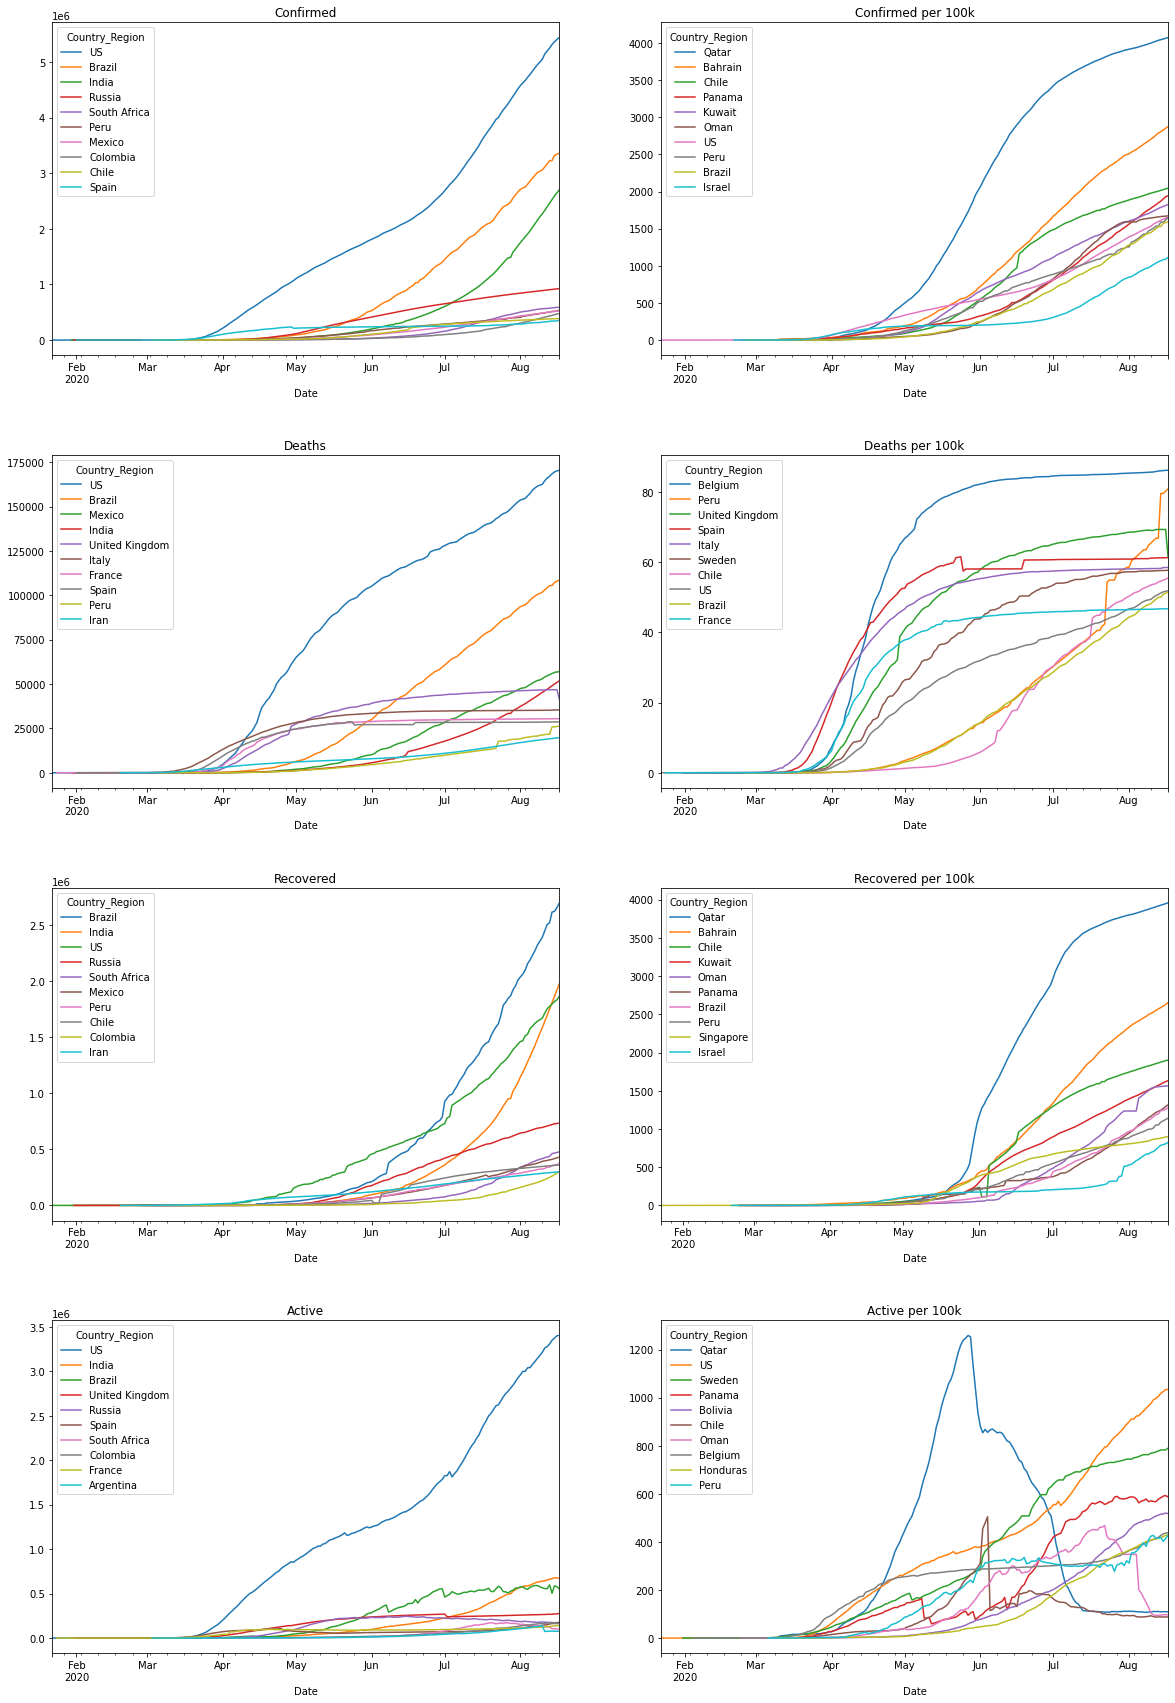

In [38]:
fig, axes = plt.subplots(4, 2, figsize=(20,30))
for i, column in enumerate(covid.columns):
    ax_r = i % 4
    ax_c = int(i/4)
    ax = axes[ax_r, ax_c]
    top_countries = covid_max.nlargest(n=10, columns=column, keep='all').sort_values(by=column, ascending=False).index
    p = covid.loc[top_countries]
    p = p.pivot_table(index=p.index.get_level_values('Date'), 
                      columns=p.index.get_level_values('Country_Region'), 
                      values=column)

    p = p.reindex(columns=top_countries)
    p.plot(title=column.replace('_', ' '), logy=False, ax=ax)

fig.subplots_adjust(hspace=0.3)

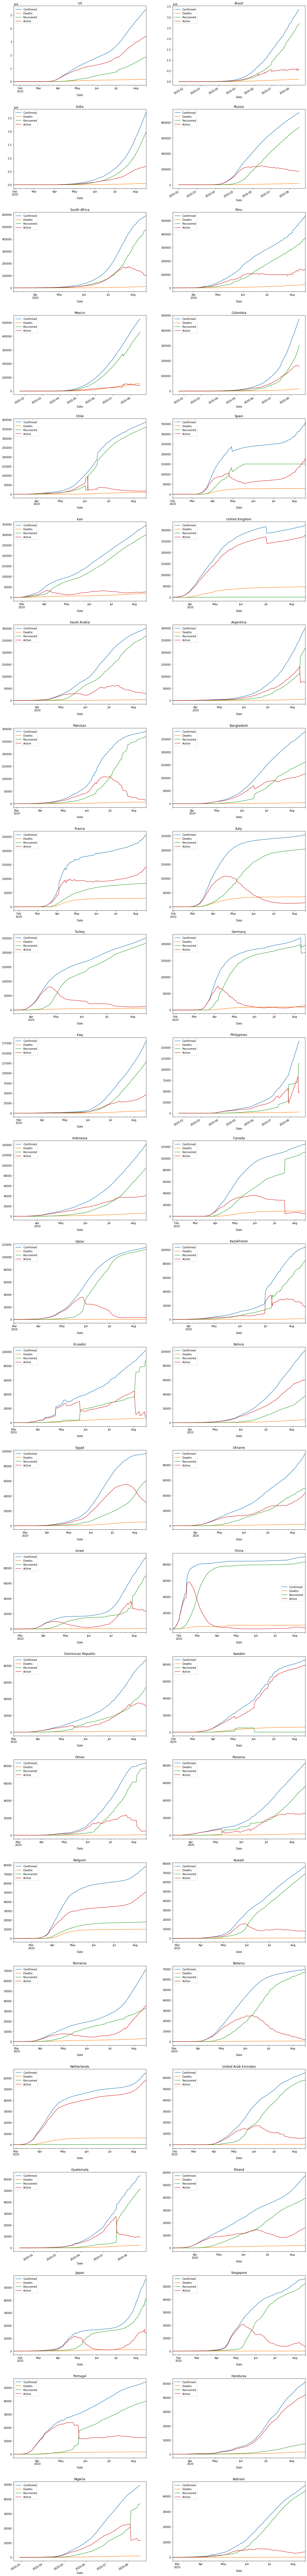

In [39]:
from math import ceil
top_countries = covid_max.nlargest(n=N_TOP_IMPACTED, columns='Confirmed').index
fig, axes = plt.subplots(int(ceil(N_TOP_IMPACTED / 2)), 2, figsize=(20, 4 * N_TOP_IMPACTED))
for i, country in enumerate(top_countries):
    ax_r = int(i / 2)
    ax_c = i % 2
    ax = axes[ax_r, ax_c]
    covid.loc[country].plot(y=['Confirmed', 'Deaths', 'Recovered', 'Active'], 
                            ax = ax, title=country, logy=False)
    

fig.subplots_adjust(hspace=0.3)

We want to add columns with differences. To smooth the differences we calculate the differences on a rolling window (size 5)

In [40]:
d=covid.groupby(level='Country_Region').rolling(window=ROLLING_WINDOW).mean().diff()
d

Confirmed  Deaths  Recovered  \
Country_Region Country_Region Date                                       
Argentina      Argentina      2020-03-03        NaN     NaN        NaN   
                              2020-03-04        NaN     NaN        NaN   
                              2020-03-05        NaN     NaN        NaN   
                              2020-03-06        NaN     NaN        NaN   
                              2020-03-07        NaN     NaN        NaN   
...                                             ...     ...        ...   
United Kingdom United Kingdom 2020-08-13      827.8    28.0        6.0   
                              2020-08-14      609.4    26.4        6.0   
                              2020-08-15     1168.0    36.0        4.6   
                              2020-08-16     1389.8    36.0        4.4   
                              2020-08-17     1096.6 -1067.4        3.6   

                                          Active  Confirmed_per_100k  \
Country_Region Country_Region Date                                     
Argentina      Argentina      2020-03-03     NaN                 NaN   
                              2020-03-04     NaN                 NaN   
                              2020-03-05     NaN                 NaN   
                              2020-03-06     NaN                 NaN   
                              2020-03-07     NaN                 NaN   
...                                          ...                 ...   
United Kingdom United Kingdom 2020-08-13   793.8            1.225823   
                              2020-08-14   577.0            0.902412   
                              2020-08-15  1127.4            1.729598   
                              2020-08-16  1349.4            2.058043   
                              2020-08-17  2160.4            1.623867   

                                          Deaths_per_100k  Recovered_per_100k  \
Country_Region Country_Region Date                                              
Argentina      Argentina      2020-03-03              NaN                 NaN   
                              2020-03-04              NaN                 NaN   
                              2020-03-05              NaN                 NaN   
                              2020-03-06              NaN                 NaN   
                              2020-03-07              NaN                 NaN   
...                                                   ...                 ...   
United Kingdom United Kingdom 2020-08-13         0.041463            0.008885   
                              2020-08-14         0.039094            0.008885   
                              2020-08-15         0.053310            0.006812   
                              2020-08-16         0.053310            0.006516   
                              2020-08-17        -1.580627            0.005331   

                                          Active_per_100k  
Country_Region Country_Region Date                         
Argentina      Argentina      2020-03-03              NaN  
                              2020-03-04              NaN  
                              2020-03-05              NaN  
                              2020-03-06              NaN  
                              2020-03-07              NaN  
...                                                   ...  
United Kingdom United Kingdom 2020-08-13         1.175475  
                              2020-08-14         0.854433  
                              2020-08-15         1.669476  
                              2020-08-16         1.998218  
                              2020-08-17         3.199163  

[8974 rows x 8 columns]

For some reason the 1st index level is duplicated

In [41]:
d = d.reset_index(level=0, drop=True)
d

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Argentina      2020-03-03        NaN     NaN        NaN     NaN   
               2020-03-04        NaN     NaN        NaN     NaN   
               2020-03-05        NaN     NaN        NaN     NaN   
               2020-03-06        NaN     NaN        NaN     NaN   
               2020-03-07        NaN     NaN        NaN     NaN   
...                              ...     ...        ...     ...   
United Kingdom 2020-08-13      827.8    28.0        6.0   793.8   
               2020-08-14      609.4    26.4        6.0   577.0   
               2020-08-15     1168.0    36.0        4.6  1127.4   
               2020-08-16     1389.8    36.0        4.4  1349.4   
               2020-08-17     1096.6 -1067.4        3.6  2160.4   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2020-03-03                 NaN              NaN   
               2020-03-04                 NaN              NaN   
               2020-03-05                 NaN              NaN   
               2020-03-06                 NaN              NaN   
               2020-03-07                 NaN              NaN   
...                                       ...              ...   
United Kingdom 2020-08-13            1.225823         0.041463   
               2020-08-14            0.902412         0.039094   
               2020-08-15            1.729598         0.053310   
               2020-08-16            2.058043         0.053310   
               2020-08-17            1.623867        -1.580627   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Argentina      2020-03-03                 NaN              NaN  
               2020-03-04                 NaN              NaN  
               2020-03-05                 NaN              NaN  
               2020-03-06                 NaN              NaN  
               2020-03-07                 NaN              NaN  
...                                       ...              ...  
United Kingdom 2020-08-13            0.008885         1.175475  
               2020-08-14            0.008885         0.854433  
               2020-08-15            0.006812         1.669476  
               2020-08-16            0.006516         1.998218  
               2020-08-17            0.005331         3.199163  

[8974 rows x 8 columns]

Verify that the rolling values get reset at the country boundaries

In [42]:
len_of_first_group = d.loc[d.index.get_level_values(0)[0]].shape[0]
len_of_first_group

168

In [43]:
d.iloc[len_of_first_group-ROLLING_WINDOW:len_of_first_group+ROLLING_WINDOW*2]

Confirmed  Deaths  Recovered   Active  \
Country_Region Date                                                
Argentina      2020-08-13     6852.2   167.8    16838.4 -10154.0   
               2020-08-14     7187.6   184.2    18152.6 -11149.2   
               2020-08-15     7046.4   174.6    19491.0 -12619.2   
               2020-08-16     6731.6   139.8     6062.6    529.2   
               2020-08-17     6110.4   120.2     6113.4   -123.2   
Bahrain        2020-02-24        NaN     NaN        NaN      NaN   
               2020-02-25        NaN     NaN        NaN      NaN   
               2020-02-26        NaN     NaN        NaN      NaN   
               2020-02-27        NaN     NaN        NaN      NaN   
               2020-02-28        NaN     NaN        NaN      NaN   
               2020-02-29        8.0     0.0        0.0      8.0   
               2020-03-01        4.8     0.0        0.0      4.8   
               2020-03-02        3.2     0.0        0.0      3.2   
               2020-03-03        3.2     0.0        0.0      3.2   
               2020-03-04        3.2     0.0        0.0      3.2   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2020-08-13           15.301690         0.374715   
               2020-08-14           16.050674         0.411338   
               2020-08-15           15.735359         0.389900   
               2020-08-16           15.032377         0.312188   
               2020-08-17           13.645172         0.268419   
Bahrain        2020-02-24                 NaN              NaN   
               2020-02-25                 NaN              NaN   
               2020-02-26                 NaN              NaN   
               2020-02-27                 NaN              NaN   
               2020-02-28                 NaN              NaN   
               2020-02-29            0.487459         0.000000   
               2020-03-01            0.292475         0.000000   
               2020-03-02            0.194984         0.000000   
               2020-03-03            0.194984         0.000000   
               2020-03-04            0.194984         0.000000   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Argentina      2020-08-13           37.601934       -22.674960  
               2020-08-14           40.536682       -24.897347  
               2020-08-15           43.525472       -28.180013  
               2020-08-16           13.538429         1.181760  
               2020-08-17           13.651871        -0.275119  
Bahrain        2020-02-24                 NaN              NaN  
               2020-02-25                 NaN              NaN  
               2020-02-26                 NaN              NaN  
               2020-02-27                 NaN              NaN  
               2020-02-28                 NaN              NaN  
               2020-02-29            0.000000         0.487459  
               2020-03-01            0.000000         0.292475  
               2020-03-02            0.000000         0.194984  
               2020-03-03            0.000000         0.194984  
               2020-03-04            0.000000         0.194984

In [44]:
covid=covid.join(other=d,rsuffix='_diff')
covid.iloc[80:95]

Confirmed  Deaths  Recovered   Active  \
Country_Region Date                                                
Argentina      2020-05-22    10649.0   433.0     3062.0   7154.0   
               2020-05-23    11353.0   445.0     3530.0   7378.0   
               2020-05-24    12076.0   452.0     3732.0   7892.0   
               2020-05-25    12628.0   467.0     3999.0   8162.0   
               2020-05-26    13228.0   484.0     4167.0   8577.0   
               2020-05-27    13933.0   500.0     4349.0   9084.0   
               2020-05-28    14702.0   508.0     4617.0   9577.0   
               2020-05-29    15419.0   520.0     4788.0  10111.0   
               2020-05-30    16214.0   528.0     4788.0  10898.0   
               2020-05-31    16851.0   539.0     5336.0  10976.0   
               2020-06-01    17415.0   556.0     5521.0  11338.0   
               2020-06-02    18319.0   569.0     5709.0  12041.0   
               2020-06-03    19268.0   583.0     5896.0  12789.0   
               2020-06-04    20197.0   608.0     5993.0  13596.0   
               2020-06-05    21037.0   632.0     6088.0  14317.0   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2020-05-22           23.780347         0.966935   
               2020-05-23           25.352454         0.993732   
               2020-05-24           26.966990         1.009364   
               2020-05-25           28.199664         1.042861   
               2020-05-26           29.539528         1.080823   
               2020-05-27           31.113868         1.116553   
               2020-05-28           32.831126         1.134418   
               2020-05-29           34.432263         1.161215   
               2020-05-30           36.207583         1.179080   
               2020-05-31           37.630071         1.203644   
               2020-06-01           38.889543         1.241607   
               2020-06-02           40.908271         1.270637   
               2020-06-03           43.027489         1.301901   
               2020-06-04           45.102045         1.357729   
               2020-06-05           46.977854         1.411323   

                           Recovered_per_100k  Active_per_100k  \
Country_Region Date                                              
Argentina      2020-05-22            6.837771        15.975641   
               2020-05-23            7.882865        16.475857   
               2020-05-24            8.333952        17.623674   
               2020-05-25            8.930191        18.226612   
               2020-05-26            9.305353        19.153351   
               2020-05-27            9.711779        20.285536   
               2020-05-28           10.310251        21.386457   
               2020-05-29           10.692112        22.578936   
               2020-05-30           10.692112        24.336391   
               2020-05-31           11.915854        24.510573   
               2020-06-01           12.328979        25.318957   
               2020-06-02           12.748803        26.888831   
               2020-06-03           13.166394        28.559194   
               2020-06-04           13.383005        30.361311   
               2020-06-05           13.595150        31.971381   

                           Confirmed_diff  Deaths_diff  Recovered_diff  \
Country_Region Date                                                      
Argentina      2020-05-22           516.2         12.0            98.6   
               2020-05-23           596.4         12.6           181.0   
               2020-05-24           653.4         11.8           172.0   
               2020-05-25           669.0         12.8           213.2   
               2020-05-26           659.4         13.6           227.0   
               2020-05-27           656.8         13.4           257.4   
               2020-05-28       

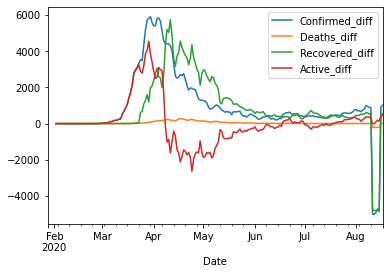

In [45]:
covid.loc[('Germany',),['Confirmed_diff', 'Deaths_diff', 'Recovered_diff', 'Active_diff']].plot()

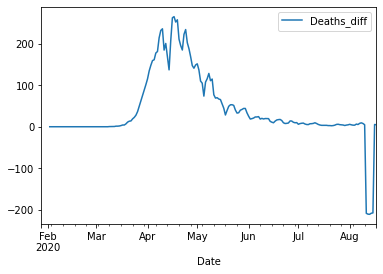

In [46]:
covid.loc[('Germany',),['Deaths_diff']].plot()

In [47]:
display(HTML(covid.loc[('Germany',),['Deaths','Deaths_diff']].to_html()))

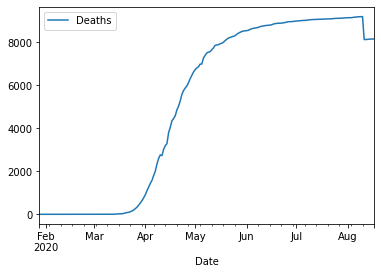

In [48]:
covid.loc[('Germany',),['Deaths']].plot()

In [49]:
display(HTML(covid.loc[('Germany',),['Confirmed_diff', 'Deaths_diff', 'Recovered_diff', 'Active_diff']].to_html()))

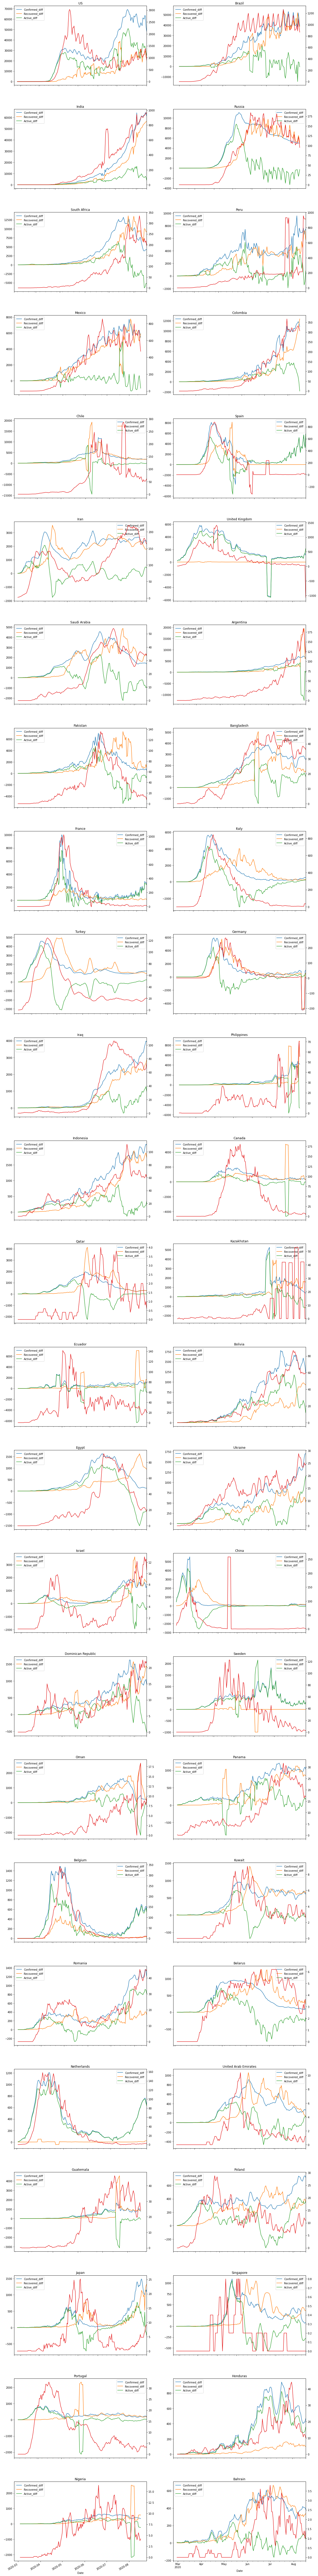

In [50]:
from math import ceil
top_countries = covid_max.nlargest(n=N_TOP_IMPACTED, columns='Confirmed').index
fig, axes = plt.subplots(int(ceil(N_TOP_IMPACTED / 2)), 2, figsize=(20, 4 * N_TOP_IMPACTED))
for i, country in enumerate(top_countries):
    ax_r = int(i / 2)
    ax_c = i % 2
    ax = axes[ax_r, ax_c]
    covid.loc[country,['Confirmed_diff', 'Recovered_diff', 'Active_diff']].plot(ax=ax, title=country)
    ax2=ax.twinx()
    covid.loc[country,['Deaths_diff']].plot(ax=ax2, colormap='Set1')
    ax2.get_legend().remove()
    
fig.subplots_adjust(hspace=0.3)

In [51]:
N_TOP_IMPACTED

50